In [1]:
#!/usr/bin/env python3
import numpy as np
import math
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from keras.utils import to_categorical
from keras.utils import plot_model
import IPython.display
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

Using TensorFlow backend.


In [2]:
#if i want to speed up and use one file
#files2 = "CSVLog_20190518_122417.csv"

#i aggregate the data points for five files into aggregate.csv. i have removed the time predictor from the data set
files = "aggregate_no_time_column.csv"

raw_dataset = pd.read_csv(files, sep=",", skipinitialspace=True)
dataset = raw_dataset.copy()

#remove whitespace in front of column name
dataset.columns = dataset.columns.str.lstrip()

In [3]:
dataset.tail()

,Absolute load value (%),Absolute throttle position (%),Ambient air temperature (F),Barometric pressure (inHg),Calculated load value (%),Commanded fuel rail pressure A (inHg),Engine coolant temperature (F),Engine RPM (RPM),Fuel level input (%),Fuel rail pressure (psi),Fuel/Air commanded equivalence ratio,Ignition timing advance for #1 cylinder (deg),Intake air temperature (F),Intake manifold absolute pressure (inHg),Long term fuel % trim - Bank 1 (%),Mass air flow rate (lb/min),Vehicle speed (MPH),Fuel rate (gal/hr),Instant fuel economy (MPG),Total fuel economy (MPG)
6633,18.03922,11.76471,59.0,29.8254,29.01961,885.903,183.2,658.75,67.05882,424.9606,0.994239,5.0,71.6,11.51674,-0.78125,0.308259,0.0,0.205909,0.0,30.11613
6634,17.64706,11.76471,59.0,29.8254,29.01961,885.903,183.2,640.00,67.05882,449.6170,0.994239,4.5,71.6,11.51674,-0.78125,0.257985,0.0,0.172327,0.0,30.11534
6635,17.64706,11.37255,59.0,29.8254,29.41176,885.903,183.2,607.75,67.05882,429.3117,0.994239,4.0,71.6,11.51674,-0.78125,0.325458,0.0,0.217398,0.0,30.11455
6636,17.25490,11.37255,59.0,29.8254,29.41176,885.903,183.2,606.75,67.05882,449.6170,0.994239,6.5,71.6,11.51674,-0.78125,0.239463,0.0,0.159955,0.0,30.11384
6637,17.64706,11.37255,59.0,29.8254,29.80392,885.903,183.2,604.50,67.05882,429.3117,0.994239,6.0,71.6,11.51674,-0.78125,0.227556,0.0,0.152002,0.0,30.11316


In [4]:
%%time 
#set seed here!

#creating data and splitting and random shuffling
#https://stackoverflow.com/questions/38250710/how-to-split-data-into-3-sets-train-validation-and-test/38251213#38251213
def train_validate_test_split(df, train_percent=.6, validate_percent=.2, seed=None):
    np.random.seed(seed)
    perm = np.random.permutation(df.index)
    m = len(df.index)
    train_end = int(train_percent * m)
    validate_end = int(validate_percent * m) + train_end
    train = df.loc[perm[:train_end]]
    validate = df.loc[perm[train_end:validate_end]]
    test = df.loc[perm[validate_end:]]
    return train, validate, test

np.random.seed(88)
train, validate, test = train_validate_test_split(dataset)

train_labels = train.pop("Total fuel economy (MPG)")
validate_labels = validate.pop("Total fuel economy (MPG)")
test_labels = test.pop("Total fuel economy (MPG)")


CPU times: user 8.87 ms, sys: 8.46 ms, total: 17.3 ms
Wall time: 29 ms


In [5]:
#test_labels
#train.dtypes

In [6]:
train = train.apply(lambda col:pd.to_numeric(col, errors='coerce'))
train_stats = train.describe(include = 'all')
#train_stats = train.transpose()
train_stats


,Absolute load value (%),Absolute throttle position (%),Ambient air temperature (F),Barometric pressure (inHg),Calculated load value (%),Commanded fuel rail pressure A (inHg),Engine coolant temperature (F),Engine RPM (RPM),Fuel level input (%),Fuel rail pressure (psi),Fuel/Air commanded equivalence ratio,Ignition timing advance for #1 cylinder (deg),Intake air temperature (F),Intake manifold absolute pressure (inHg),Long term fuel % trim - Bank 1 (%),Mass air flow rate (lb/min),Vehicle speed (MPH),Fuel rate (gal/hr),Instant fuel economy (MPG)
count,3982.000000,3982.000000,3982.000000,3982.000000,3982.00000,3982.000000,3982.000000,3982.000000,3982.000000,3982.000000,3982.000000,3982.000000,3982.000000,3982.000000,3982.000000,3982.000000,3982.000000,3982.000000,3982.000000
mean,34.895362,21.365951,67.652235,29.722171,42.78715,1853.885910,185.410196,1511.247740,74.532258,925.258093,0.980674,21.105726,73.338272,17.720581,5.400278,1.493496,31.259091,1.009300,60.519365
std,24.259206,13.811031,12.482209,0.692951,26.17929,1169.540494,8.415073,643.551872,10.951572,567.655410,0.035960,15.191100,13.845385,8.812450,3.939965,1.557876,22.621074,1.048062,79.664051
min,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-11.000000,0.000000,0.000000,-2.343750,0.000000,0.000000,0.000000,0.000000
25%,16.078430,12.156860,62.600000,29.530100,20.78431,885.903000,183.200000,1068.812500,67.450980,478.624500,0.990274,4.500000,64.400000,10.335540,2.343750,0.313882,11.184680,0.211827,11.310987
50%,25.098040,15.686270,62.600000,29.825400,38.82353,1219.593000,185.000000,1477.125000,74.509800,617.860800,0.993111,23.500000,68.000000,15.355650,5.468750,0.844735,31.068560,0.580611,31.816160
75%,49.411770,26.666670,66.200000,29.825400,56.86274,2580.192750,188.600000,1987.750000,81.176470,1267.630000,0.995520,35.500000,77.000000,27.167690,7.812500,2.220986,45.360100,1.507979,81.838710
max,98.039220,90.980390,118.400000,30.120700,100.00000,5906.020000,204.800000,4719.500000,93.333340,2937.014000,1.016260,47.500000,122.000000,30.711300,12.500000,11.867310,76.428660,7.964196,1252.727000


In [7]:
type(train_stats)

pandas.core.frame.DataFrame

In [8]:
#https://stackoverflow.com/questions/40758562/can-anyone-explain-me-standardscaler
scaler = StandardScaler()
normed_train = scaler.fit_transform(train)
normed_validate = scaler.fit_transform(validate)
normed_test = scaler.fit_transform(test)

#not technically correct
#from tf regression website
#Note: Although we intentionally generate these statistics from only the training dataset, 
#these statistics will also be used to normalize the test dataset. We need to do that to project the test 
#dataset into the same distribution that the model has been trained on.

#I normalize it according to the mean and sd of each predictor from each set instead of normalizaing from 
#training set only

In [9]:
#debugging
#normed_train

In [10]:
def build_model():
  model = keras.Sequential([
    layers.Dense(10, activation=tf.nn.relu, input_shape=[len(train.keys())]),
    layers.Dense(5, activation=tf.nn.relu),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mean_squared_error',
                optimizer=optimizer,
                metrics=['mean_absolute_error', 'mean_squared_error'])
  return model

In [11]:
%%time
model = build_model()
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                200       
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 55        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 6         
Total params: 261
Trainable params: 261
Non-trainable params: 0
_________________________________________________________________
CPU times: user 178 ms, sys: 13.1 ms, total: 192 ms
Wall time: 224 ms


In [12]:
%%time
#change batch size?
#try early stop?
# The patience parameter is the amount of epochs to check for improvement
#early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

#history_object = model.fit(train, train_labels, epochs=100, verbose=2,
#         validation_data=(validate, validate_labels), callbacks=[early_stop])

history_object = model.fit(normed_train, train_labels, epochs=100, verbose=2,
         validation_data=(normed_validate, validate_labels))


Train on 3982 samples, validate on 1327 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/100
 - 0s - loss: 862.8505 - mean_absolute_error: 29.1840 - mean_squared_error: 862.8507 - val_loss: 848.2684 - val_mean_absolute_error: 28.9603 - val_mean_squared_error: 848.2684
Epoch 2/100
 - 0s - loss: 833.5561 - mean_absolute_error: 28.6806 - mean_squared_error: 833.5558 - val_loss: 833.0792 - val_mean_absolute_error: 28.6964 - val_mean_squared_error: 833.0791
Epoch 3/100
 - 0s - loss: 817.7832 - mean_absolute_error: 28.4034 - mean_squared_error: 817.7834 - val_loss: 809.1597 - val_mean_absolute_error: 28.2736 - val_mean_squared_error: 809.1597
Epoch 4/100
 - 0s - loss: 776.2686 - mean_absolute_error: 27.6566 - mean_squared_error: 776.2688 - val_loss: 748.6182 - val_mean_absolute_error: 27.1651 - val_mean_squared_error: 748.6182
Epoch 5/100
 - 0s - loss: 698.3908 - mean_absolute_error: 26.1754 - mean_squared_error: 698.3908 - val_loss: 649.0045 - val_mean_absolute_error: 25.1969

Epoch 45/100
 - 0s - loss: 4.1030 - mean_absolute_error: 1.5233 - mean_squared_error: 4.1030 - val_loss: 5.7508 - val_mean_absolute_error: 1.9446 - val_mean_squared_error: 5.7508
Epoch 46/100
 - 0s - loss: 4.0809 - mean_absolute_error: 1.5153 - mean_squared_error: 4.0809 - val_loss: 5.9978 - val_mean_absolute_error: 1.9982 - val_mean_squared_error: 5.9978
Epoch 47/100
 - 0s - loss: 4.0268 - mean_absolute_error: 1.5071 - mean_squared_error: 4.0268 - val_loss: 5.8159 - val_mean_absolute_error: 1.9264 - val_mean_squared_error: 5.8159
Epoch 48/100
 - 0s - loss: 4.0006 - mean_absolute_error: 1.5042 - mean_squared_error: 4.0006 - val_loss: 5.7408 - val_mean_absolute_error: 1.9372 - val_mean_squared_error: 5.7408
Epoch 49/100
 - 0s - loss: 3.9574 - mean_absolute_error: 1.5024 - mean_squared_error: 3.9574 - val_loss: 6.1646 - val_mean_absolute_error: 1.9872 - val_mean_squared_error: 6.1646
Epoch 50/100
 - 0s - loss: 3.9704 - mean_absolute_error: 1.4997 - mean_squared_error: 3.9704 - val_loss: 

Epoch 91/100
 - 0s - loss: 3.5736 - mean_absolute_error: 1.4269 - mean_squared_error: 3.5736 - val_loss: 5.8322 - val_mean_absolute_error: 1.9533 - val_mean_squared_error: 5.8322
Epoch 92/100
 - 0s - loss: 3.5844 - mean_absolute_error: 1.4273 - mean_squared_error: 3.5844 - val_loss: 5.7969 - val_mean_absolute_error: 1.9494 - val_mean_squared_error: 5.7969
Epoch 93/100
 - 0s - loss: 3.5652 - mean_absolute_error: 1.4237 - mean_squared_error: 3.5652 - val_loss: 5.6208 - val_mean_absolute_error: 1.9247 - val_mean_squared_error: 5.6208
Epoch 94/100
 - 0s - loss: 3.5741 - mean_absolute_error: 1.4303 - mean_squared_error: 3.5741 - val_loss: 5.6900 - val_mean_absolute_error: 1.9201 - val_mean_squared_error: 5.6900
Epoch 95/100
 - 0s - loss: 3.5549 - mean_absolute_error: 1.4227 - mean_squared_error: 3.5549 - val_loss: 5.4897 - val_mean_absolute_error: 1.9042 - val_mean_squared_error: 5.4897
Epoch 96/100
 - 0s - loss: 3.5685 - mean_absolute_error: 1.4297 - mean_squared_error: 3.5685 - val_loss: 

In [13]:
#history_object.history

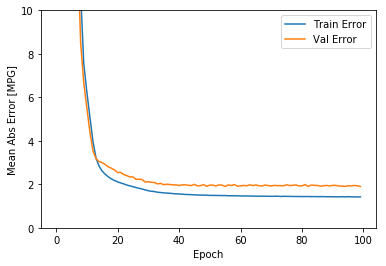

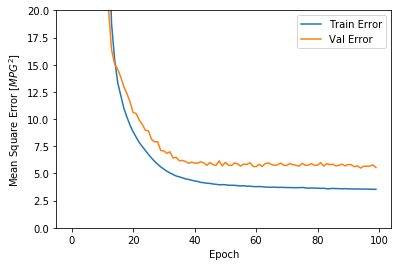

In [14]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
  plt.ylim([0,10])
  plt.legend()
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
  plt.ylim([0,20])
  plt.legend()
  plt.show()

plot_history(history_object)

In [15]:
#loss, mae, mse = model.evaluate(test, test_labels, verbose=2)
#normed_test[:10]

In [16]:
test_predictions = model.predict(normed_test).flatten()

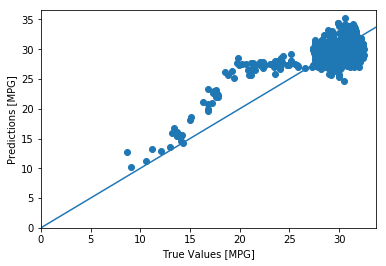

In [17]:
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

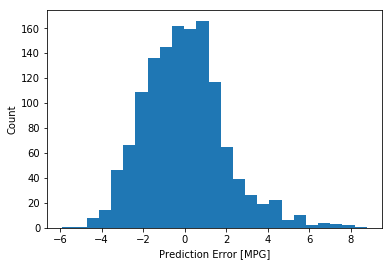

In [18]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")

In [19]:
percent_error = error / test_labels
percent_error.mean()

0.0055726692738906815